In [1]:
using DataFrames
using Plots
pyplot()

Plots.PyPlotBackend()

# Description of DFM

## Static Form of the DFM
Equation (6) 
$$X_t=\Lambda F_t+e_t$$
Equation (7)
$$F_t=\Phi(L)F_{t-1}+G\eta_t$$

### Principal Components Normalization
Equation (11) in the paper
$$\frac{1}{N}\Lambda'\Lambda=I_r$$ and $\Sigma_F\equiv E\left[F_tF_t^\prime\right]$ diagonal.

#### Principal Components Estimation
Equation (13)
$$\min_{F_1,\dots,F_T,\Lambda}V_r(\Lambda,F)$$
where
$$V_r\left(\Lambda,F\right)=\frac{1}{NT}\sum_{t=1}^T\left(X_t-\Lambda F_t\right)'\left(X_t-\Lambda F_t\right)$$

# Figure 1
Figure 1 assumes there is only one factor which evoles as
$$f_t = \Psi_4f_{t-1=}+\dots+\Psi_4f_{t-4}.$$
All observed variables $y_t$ depend on the current value of $f$ and from first to fourth lags of $f$, and constant:
$$X_{it} = \lambda_i+\lambda_{i0}f_t+\lambda_{i1}f_{t1}+\dots+\lambda_{i4}f_{t4}.$$

In [2]:
nt_min = 20 # min number of obs for any series used to est factors

20

#### Useful functions

In [3]:
nanf(f::Function, x) = f(filter(!isnan, x))
nanmean(x) = nanf(mean, x)
nanstd(x) = nanf(std, x)
nansum(x) = nanf(sum, x)

nansum (generic function with 1 method)

In [4]:
apply_f_vertically(f::Function, df::DataFrame) =
    Matrix(map(f, eachcol(df)))
nanmean(df::DataFrame) = apply_f_vertically(nanmean, df)
nanstd(df::DataFrame) = apply_f_vertically(nanstd, df)
nansum(df::DataFrame) = apply_f_vertically(nansum, df)

nansum (generic function with 2 methods)

In [5]:
function dropna_row(df::DataFrame)
    numrows = completecases(df)
    return df[numrows, :], numrows
end
function dropna_col(df::DataFrame) 
    df_dropped, numcolt= dropna_row(df')
    return df_dropped', numcolt'
end

dropna_col (generic function with 1 method)

In [6]:
"""
##### Outputs
- `numrow`: Vector of Bool where false indicates the row has `NaN` data.
"""
function dropna_row(A::Matrix)
    numrow = .!vec(any(isnan.(A), 2))
    return A[numrow, :], numrow
end
"""
##### Outputs
- `numcolt'`: RowVector of Bool where false indicates the column has `NaN` data.
"""
function dropna_col(A::Matrix)
    At_dropped, numcolt = dropna_row(A')
    return At_dropped', numcolt'
end

dropna_col (generic function with 2 methods)

In [7]:
function pca_score(X, nfac_u)
    _, _, V = svd(X)
    score = (X*V)[:, 1:nfac_u]
    return score
end

pca_score (generic function with 1 method)

In [8]:
"""
##### Arguments
- `y::AbstractVector`: length `T` Vector or `TxN` Matrix where `T`
                       is sample size and `N` is the number of 
                       regressed variables
- `X::AbstractArray`: `TxK` Matrix where `K` is the number of
                      regressors
##### Outputs
- `b`: OLS estimator of the coefficients
- `e`: residual
"""
function ols(y::AbstractArray, X::AbstractArray)
    b = X\y
    e = y - X*b
    return b, e
end

"""
do OLS ignoring samples containing NaN
"""
function nanols(y::AbstractArray, X::AbstractArray)
    N = size(y, 2)
    tmp, numrow = dropna_row([y X])
    y_used, x_used = tmp[:, 1:N], tmp[:, N+1:end]
    b, e = ols(y_used, x_used)
    return b, e, numrow
end

nanols

In [9]:
function lagmat(X::Array, lags::AbstractVector)
    nc = size(X, 2)
    Xlag = fill(NaN, size(X, 1), nc*length(lags))
    for (i, lag) in enumerate(lags)
        Xlag[lag+1:end, nc*(i-1)+1:nc*i] .= X[1:end-lag, :]
    end
    return Xlag
end
lagmat(X::Array, lag::Integer) = lagmat(X, [lag])

lagmat (generic function with 2 methods)

In [10]:
"""
`x::Array`: `nxk` matrix or vector of length `n` 
`xlag::Matrix`: `nxk` matrix
"""
function lag(x::Array, p::Integer)
    if p >= 0
        return vcat(fill(NaN, p, size(x, 2)), x[1:end-p, :])
    else
        return vcat(x[1-p:end, :], fill(NaN, -p, size(x, 2)))
    end
end

lag

In [11]:
function uar(y::Array, n_lags::Integer)
    x = Matrix{Float64}(size(y, 1), size(y, 2)*n_lags)
    for i = 1:n_lags
        x[:, size(y, 2)*(i-1)+1:size(y, 2)*i] = lag(y, i)
    end
    bols, ehat, _ = nanols(y, x)
    ssr = dot(ehat, ehat)
    ser = sqrt(ssr/(size(x, 1)-size(x, 2)))
    arcoef = bols
    return arcoef, ser
end

uar (generic function with 1 method)

## Import data

In [12]:
data = readcsv("data/bpdata.csv")
header = data[1, :]
year = data[2:end, 1]
data = Float64.(data[2:end, 2:end])

224×86 Array{Float64,2}:
 NaN            NaN            NaN            …  12.3235     NaN          
   0.0142268      0.00530395     0.0228269        9.45272      0.0152701  
  -0.0116989      0.000417996    0.0050264       -4.38442      0.00203857 
  -0.00581949    -0.00882744    -0.0629256       -2.85467     -0.00647572 
   0.012316      -0.000459845    0.0175352       -0.758017     0.0188318  
  -0.0134915      0.00268641     0.0084729    …  -8.42778     -0.00129345 
  -0.00717594    -0.0139067     -0.0219165       -6.79728     -0.00454431 
  -0.0218157     -0.00861225    -0.0393015       -8.76649     -0.0154271  
  -0.00283434    -0.0101246     -0.0704661       -6.96877     -0.0272235  
   0.00883281     0.00493428     0.0066869        8.19584     -0.0158283  
   0.00697616    -0.00494625     0.0103326    …   8.36063     -0.00347905 
   0.0105292      0.0100276      0.0335589       11.6922       0.000487977
   0.00833999     0.000812098    0.00756745       3.22391      0.0073634  


## Restrict sample

In [13]:
initperiod = 3 # first two observations are dropped

# exclude year data
xdata = Float64.(data[initperiod:end, :])

222×86 Array{Float64,2}:
 -0.0116989     0.000417996   0.0050264    …  -4.38442      0.00203857 
 -0.00581949   -0.00882744   -0.0629256       -2.85467     -0.00647572 
  0.012316     -0.000459845   0.0175352       -0.758017     0.0188318  
 -0.0134915     0.00268641    0.0084729       -8.42778     -0.00129345 
 -0.00717594   -0.0139067    -0.0219165       -6.79728     -0.00454431 
 -0.0218157    -0.00861225   -0.0393015    …  -8.76649     -0.0154271  
 -0.00283434   -0.0101246    -0.0704661       -6.96877     -0.0272235  
  0.00883281    0.00493428    0.0066869        8.19584     -0.0158283  
  0.00697616   -0.00494625    0.0103326        8.36063     -0.00347905 
  0.0105292     0.0100276     0.0335589       11.6922       0.000487977
  0.00833999    0.000812098   0.00756745   …   3.22391      0.0073634  
  0.0012303     0.0024063     0.0127609       -2.711        0.00208582 
  1.74e-5      -0.0016512    -0.00655048      -4.1126       0.00443766 
  ⋮                                    

## Standardize data

In [14]:
xdata_df = DataFrame(xdata)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86
1,-0.0116989,0.000417996,0.0050264,0.00246625,-0.00326463,-0.0790124,-0.00147975,0.0152494,0.0118482,-0.024915,-0.00498891,0.00169134,0.00930034,-0.0202841,-0.00935316,0.0144959,-0.00573149,-0.0116777,-0.015238,-0.0152102,-0.0525197,0.00228093,0.000971413,-0.120124,-0.194273,-0.00975078,-0.0102119,-0.046722,0.00410129,0.00205324,NaN,-0.00610939,-0.00668619,-0.0104329,-0.00291447,-0.0112856,-0.0213455,0.00520428,-0.00943522,-0.00440014,-0.000743416,-0.00819408,-0.00570289,-0.00245758,-0.00394874,-0.0340392,-0.00120518,-0.00260217,0.000426697,0.0068248,-0.004025,-0.00662232,-0.000251359,-0.00320003,0.000580855,0.167021,0.404021,-0.156578,0.717014,0.281716,-0.133852,0.0582626,0.163721,0.0289703,-0.201499,NaN,NaN,NaN,NaN,0.0360857,-0.0124779,-0.00691635,-0.0533992,NaN,-0.0770044,-13.9848,-0.0252816,-0.00118184,-0.0989509,-0.0596414,-0.015713,0.00104151,2.50052,1.51749,-4.38442,0.00203857
2,-0.00581949,-0.00882744,-0.0629256,0.00114872,-0.000902454,0.0198127,-0.0236725,-0.0187833,-0.0173627,-0.0347269,-0.000507128,-0.0149292,-0.0137298,-0.00462032,-0.0154895,-0.043808,-0.0407816,-0.00313488,-0.0118466,-0.00827169,-0.00593753,-0.0221506,-0.0203229,0.0129465,0.0304035,-0.0231772,-0.0656206,-0.167345,-0.00367598,-0.0269791,NaN,-0.00246852,-0.00363068,-0.00394525,-0.0002516,-0.00597977,-0.00552602,-0.00165274,-0.0176718,0.00174036,-0.000402132,-0.00452372,-0.000653176,-0.00190623,0.00135556,0.000908343,-0.00259309,0.00419802,-0.00233556,-0.0011628,0.0111912,-0.00126177,0.00254587,-0.00398937,-3.11e-5,0.332866,0.303909,-0.0111704,0.18326,0.347291,0.198872,0.0633321,0.0471377,0.1077,-0.0155907,NaN,NaN,NaN,NaN,0.0594418,-0.00401506,-0.00382656,-0.3175,NaN,-0.176789,-15.217,-0.00819928,-0.0263144,0.00191831,-0.0167168,0.00366857,-0.0364612,0.088743,-6.33572,-2.85467,-0.00647572
3,0.012316,-0.000459845,0.0175352,-0.00193086,-0.00457743,0.0836151,0.0208606,0.017329,0.0195644,0.0242492,0.00758827,-0.0237988,-0.04217,0.0640172,0.00644621,0.101338,0.0221842,0.00158135,0.0188524,0.014404,0.0478876,0.0255475,0.0282044,0.0827874,0.13637,0.0148426,0.110026,0.287095,-0.00137879,0.0244213,NaN,0.00658649,0.00769614,0.0213344,0.00246661,0.0144694,0.0340982,0.00311673,-0.0200881,0.00181508,0.000463413,0.0112676,0.00491343,0.00378385,0.00179794,0.0123577,0.00216076,0.000770416,0.00357785,-0.00213772,0.0083604,-0.00794368,-0.00010133,-0.00040705,-0.467302,-0.467931,-0.418495,-0.0207706,-1.01713,-0.420443,-0.335051,-0.0918873,-0.128545,-0.0109528,-0.035159,NaN,NaN,NaN,NaN,-0.10168,-0.00582102,0.002195,-0.114883,NaN,0.156753,-15.1148,0.0160026,0.00738099,-0.0146345,-0.00380261,-0.070814,-0.051811,-19.9552,1.67848,-0.758017,0.0188318
4,-0.0134915,0.00268641,0.0084729,0.000181831,0.00380718,-0.109974,-0.0302803,-2.92e-5,-8.04e-6,-0.0913899,-0.00216077,0.0040144,-0.00177329,-0.0193272,0.0137121,0.0449954,-0.0075092,-0.00396232,-0.0220478,-0.0194146,-0.0325454,-0.0110202,-0.00459917,-0.0610088,-0.0933122,-0.0224446,-0.0288768,-0.0335815,0.00425439,-0.0204477,NaN,-0.00383928,-0.00461884,-0.0127354,-0.000178801,-0.00997505,-0.0201285,-0.0020271,0.00353996,-0.00175089,-0.000672862,-0.00622956,-0.00398063,0.00296937,-0.00183335,-0.00521506,0.00140513,0.000675359,0.00204922,-0.00279134,0.00452911,0.000650225,-0.00111869,0.00811094,0.632099,0.0979651,0.151858,-0.0586832,-0.250825,0.0451832,0.0643789,0.0844154,0.0129512,-0.0387032,-0.0863974,NaN,NaN,NaN,NaN,0.11523,0.00680841,-0.00221081,-0.41222,NaN,-0.409711,-18.0118,-0.0232244,0.0037975,-0.013849,-0.0237495,-0.0616635,0.0255509,-23.5312,-6.2066,-8.42778,-0.00129345
5,-0.00717594,-0.0139067,-0.0219165,-0.0120076,-0.0128964,-0.0146509,-0.0335632,-0.0607614,-0.0322223,-0.036276,-0.0005346

In [15]:
tmp = size(xdata, 1) - sum(isnan.(xdata), 1)
tmp = (tmp-1)./tmp

xdatamean = nanmean(xdata_df)
xdatastd = nanstd(xdata_df).*sqrt.(tmp)

data_standardized  = (xdata .- xdatamean)./xdatastd

222×86 Array{Float64,2}:
 -1.40748     0.0744596   0.173258    0.616121   …  -0.60472       0.196305 
 -0.695838   -1.32505    -2.11177     0.294728      -0.393958     -0.598907 
  1.4993     -0.0584219   0.593892   -0.456492      -0.105092      1.76475  
 -1.62447     0.417836    0.289153    0.0588688     -1.16179      -0.114897 
 -0.860024   -2.09391    -0.732752   -2.91457       -0.937152     -0.418518 
 -2.63204    -1.29248    -1.31736    -0.272196   …  -1.20846      -1.43494  
 -0.334512   -1.5214     -2.36533    -0.172815      -0.960779     -2.53669  
  1.07769     0.758103    0.229095    0.924045       1.12853      -1.47241  
  0.852962   -0.737543    0.35169    -1.85           1.15123      -0.319026 
  1.28303     1.5291      1.13272     1.66387        1.61024       0.0514838
  1.01804     0.134116    0.258706   -0.297892   …   0.443519      0.69363  
  0.157477    0.375434    0.433345    1.02332       -0.374164      0.200718 
  0.0106661  -0.238761   -0.216038   -0.488643     

### only use datas with inclcode==1 

In [16]:
inclcode = readcsv("data/inclcode.csv")

tmp = Matrix{Float64}(size(data_standardized, 1), count(inclcode.==1))
j = 0
for i = 1:size(xdata, 2)
    if inclcode[1, i] == 1
        j = j + 1
        tmp[:, j] = data_standardized[:, i]
    end
end
data_standardized = tmp

222×58 Array{Float64,2}:
  0.173258    0.616121   -0.449517    …  -0.60472       0.196305 
 -2.11177     0.294728   -0.119795       -0.393958     -0.598907 
  0.593892   -0.456492   -0.632765       -0.105092      1.76475  
  0.289153    0.0588688   0.537598       -1.16179      -0.114897 
 -0.732752   -2.91457    -1.79397        -0.937152     -0.418518 
 -1.31736    -0.272196   -0.875153    …  -1.20846      -1.43494  
 -2.36533    -0.172815   -0.148152       -0.960779     -2.53669  
  0.229095    0.924045    0.891152        1.12853      -1.47241  
  0.35169    -1.85       -0.861188        1.15123      -0.319026 
  1.13272     1.66387     0.919308        1.61024       0.0514838
  0.258706   -0.297892    0.191752    …   0.443519      0.69363  
  0.433345    1.02332    -0.40217        -0.374164      0.200718 
 -0.216038   -0.488643    0.124493       -0.567269      0.420373 
  ⋮                                   ⋱                          
  0.427577   -0.21763    -0.00601165  …   0.0423418

## Compute Total Sum of Squares

In [17]:
tss = sum(nansum(DataFrame(data_standardized.^2)))

12700.0

## Remove columns containing NaN

In [18]:
xbal, _ = dropna_col(data_standardized)

([0.173258 0.616121 … 0.258725 -0.60472; -2.11177 0.294728 … -1.11863 -0.393958; … ; 0.321295 0.265555 … 0.707057 0.925641; 0.074715 1.18534 … 0.555908 0.814873], Bool[true true … true false])

# PCA

In [19]:
nt, ns = size(data_standardized)
nfac_o = 0 # number of observed factors
nfac_u = 1 # number of unobserved factors
nfac_t = nfac_o + nfac_u # total number of factors

1

In [20]:
f = pca_score(xbal, nfac_u)
fa = f

222×1 Array{Float64,2}:
  3.59133  
  3.81922  
 -4.8285   
  3.57713  
  7.32604  
  9.797    
  8.64339  
 -0.0988581
 -2.12375  
 -5.12746  
 -2.96291  
 -1.34933  
  1.74576  
  ⋮        
 -3.2693   
 -0.524436 
 -0.440566 
 -1.56502  
 -1.99228  
 -1.82968  
 -2.3149   
 -3.62214  
 -1.37052  
 -4.2118   
 -3.41265  
 -3.06683  

# Least square

In [21]:
lambda = Matrix{Float64}(ns, nfac_t)
ssr = 0

diff = 1000
tol = 1e-8
while diff > tol*nt*ns
    ssr_old = ssr
    for i = 1:ns
        if size(data_standardized, 1) >= nt_min # if sample size is enough
            xdata_stdi = data_standardized[:, i]
            b, _, _ = nanols(xdata_stdi[:, 1], fa)
            lambda[i, :] = b'
        end
    end

    edata = data_standardized
    for t = 1:nt
        b, _, _ = nanols(edata[t, :], lambda[:, nfac_o+1:end])
        f[t, :] = b'
    end
    fa = f
    ehat = data_standardized - fa*lambda'
    ssr = sum(nansum(ehat.^2))
    diff = abs(ssr_old - ssr)
    println(diff)
end

7805.186076916562
0.48167949559046974
0.002725418577028904


In [22]:
lambda = lambda.*xdatastd

fac_est = fill(NaN, size(data, 1), nfac_t)
fac_est[initperiod:end,  :] = fa

fac = fac_est

224×1 Array{Float64,2}:
 NaN        
 NaN        
   3.55906  
   3.97141  
  -5.29767  
   3.52022  
   7.35006  
   9.7971   
   8.80436  
   0.0734791
  -2.08731  
  -5.13417  
  -2.95774  
   ⋮        
  -3.28253  
  -0.435026 
  -0.489242 
  -1.55541  
  -2.36165  
  -2.07796  
  -1.93469  
  -3.78706  
  -1.45445  
  -4.59681  
  -3.16031  
  -3.344    

4.325549707573373e-5


The above code are mostly coming from `factor_estimation_ls.m`


## Part of  `factor_estimation_ls_full.m`

In [23]:
n_series = size(data, 2)
n_uarlag = 4 # number of arlags for uniqueness

lam_mat = Matrix{Float64}(n_series, nfac_t)
uar_coef_mat = Matrix{Float64}(n_series, n_uarlag)
uar_ser_mat = Vector{Float64}(n_series)
r2_mat = Vector{Float64}(n_series)
for is = 1:n_series
    if size(tmp, 1) >= nt_min
        bols, uhat, numrow = 
            nanols(data[initperiod:end, is],
                   [fac[initperiod:end, :] ones(size(tmp, 1), 1)])
        y_used = data[initperiod:end, is][numrow, :]
        b = copy(bols)
        lam_mat[is, :] = b[1:end-1]
        ssr = sum(uhat.^2)
        ym = y_used - mean(y_used)
        tss = sum(ym.^2)
        r2_mat[is] = 1-ssr/tss
        if r2_mat[is] < 0.9999
            arcoef, ser = uar(uhat, n_uarlag)
        else
            arcoef, ser = zeros(n_uarlag, 1), 0.0
        end
    end
    uar_coef_mat[is, :] = arcoef'
    uar_ser_mat[is, 1] = ser
end

# `varest.m`

In [24]:
"""
VAR model can be expressed in state-space form:
```math
y_t = Qz_t
```
```
z_t = Mz_{t-1}+Gu_t
```
where $z_t$ has $y_t$ and lagged $y_t$s
"""
struct VARModel{TA <: AbstactArray, TM <: AbstractMatrix}
    y::TA
    nlag::TI
    withconst::Bool
    initperiod::Int
    lastperiod::Int
    T::Int
    ns::Int
    Q::TM
    M::TM
end
function VARModel(y::AbstractArray, nlag::Integer=1; 
                  withconst::Bool=true,
                  initperiod::Integer=1, lastperiod::Integer=size(y, 1))
    T, ns = size(y, 1), size(y, 2)
    Q = fill(NaN, ns, )
    return VARModel(y, nlag, withconst, initperiod, lastperiod, T, ns)
end
function estimate(varm::VARModel, compute_matrices::Bool=true)
    y_restricted = varm.y[initperiod:lastperiod, :]
    trend = initperiod:lastperiod
    
    # regressors
    withconst || (x = lagmat(y_restricted, 1:nlag))
    !withconst || (x = [ones(lastperiod-initperiod+1) lagmat(y_restricted, 1:nlag)])
    
    # do OLS ignoring the samples containing NaN
#     betahat, ehat, y_used, regressors_used = nanols(y, [x trend])
#     x_used = regressors_used[:, ]
    regressors = [x trend]
    betahat, ehat, numrows = nanols(y, regressors)
    x_used = regressors_used[:, ]
    
    K = size(regressors, 2)
    ndf = size(x_used, 1) - K # degree of freedom (T-K)
    seps = ehat'*ehat/ndf # covariance matrix of error term

    resid = fill(NaN, T, ns)
    resid[Int.(x_used[:, end]), :] = ehat
    if compute_matrices
        b = betahat[2:end, :]'
        const_coef = betahat[1, :]

        varm.M .= zeros(size(b, 2), size(b, 2))
        varm.M[1:size(b, 1), :] .= b

        if size(b, 2) > size(b, 1)
            varm.M[size(b, 1)+1:end, 1:end-size(b, 1)] .=
                eye(size(b, 2)-size(b, 1))
        end

        varm.Q .= zeros(ns, size(M, 1))
        varm.Q[1:ns, 1:ns] .= eye(ns)
        varm.G .= zeros(size(M, 1), ns)
        varm.G[1:ns, 1:ns] .= (chol(seps))'
    end
    return resid
end

LoadError: [91msyntax: invalid interpolation syntax: "$ "[39m

In [25]:
function estimate_var(y, nlag::Integer, initperiod::Integer)
    
    T, ns = size(y, 1), size(y, 2)

    x = [ones(T, 1) lagmat(y, 1:nlag)]
    trend = initperiod:T
    
    y = y[initperiod:T, :]
    x = x[initperiod:T, :]
    
    betahat, ehat, numrow = nanols(y, [x trend])
    y_used, x_used = y[numrow, :], [x trend][numrow, :]

    ndf = size(x_used, 1) - size(x_used, 2) # degree of freedom (T-K)
    seps = ehat'*ehat/ndf

    resid = fill(NaN, T, ns)
    resid[Int.(x_used[:, end]), :] = ehat

    b = betahat[2:end, :]'
    const_coef = betahat[1, :]

    M = zeros(size(b, 2), size(b, 2))
    M[1:size(b, 1), :] = b

    if size(b, 2) > size(b, 1)
        M[size(b, 1)+1:end, 1:end-size(b, 1)] =
            eye(size(b, 2)-size(b, 1))
    end

    Q = zeros(ns, size(M, 1))
    Q[1:ns, 1:ns] = eye(ns)
    G = zeros(size(M, 1), ns)
    G[1:ns, 1:ns] = (chol(seps))'
    return M, Q, G
end
estimate_var(fac, 4, initperiod)

([0.898542 -0.195667 … -0.13101 0.000909197; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0], [1.0 0.0 … 0.0 0.0], [2.83044; 0.0; … ; 0.0; 0.0])

`varest.m` part is done.

In [26]:
M, Q, G = estimate_var(fac, 4, initperiod)

([0.898542 -0.195667 … -0.13101 0.000909197; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0], [1.0 0.0 … 0.0 0.0], [2.83044; 0.0; … ; 0.0; 0.0])

In [27]:
G

5×1 Array{Float64,2}:
 2.83044
 0.0    
 0.0    
 0.0    
 0.0    

# Plotting

In [28]:
j = 1
yf = lam_mat[j, :]' * fac'

y4f = sum(lagmat(yf', 0:3), 2)
y4 = sum(lagmat(data[:, 1], 0:3), 2)

224×1 Array{Float64,2}:
 NaN          
 NaN          
 NaN          
 NaN          
   0.00902449 
  -0.0186939  
  -0.0141709  
  -0.0301671  
  -0.0453175  
  -0.0229932  
  -0.00884106 
   0.0235039  
   0.0346782  
   ⋮          
   0.00394735 
   0.000831648
   0.0049777  
  -0.00596135 
  -0.00466148 
  -0.00421219 
   0.000788617
   0.00933866 
  -0.00264566 
   0.0043127  
   0.00549259 
   0.00242789 

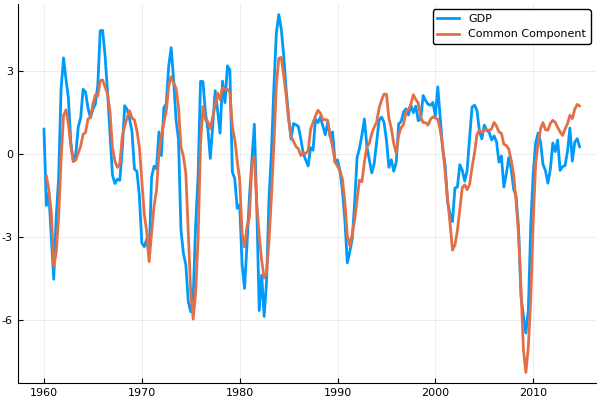

In [29]:
plot(year, [100*y4 100*y4f], lw=2, lab=["GDP" "Common Component"])